In [1]:
import numpy as np
import scipy

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm

# from matplotlib import animation 
    
from datetime import datetime
import time

In [2]:
class Evol:
    
    def maskFuncS32(self, x):
        if x >= -self.R and x <= -self.R+self.deltaM:
            return -2/self.deltaM**3 * (x+self.R-self.deltaM)**3 \
                   - 3/self.deltaM**2 * (x+self.R-self.deltaM)**2 + 1
        
        elif x >= self.R-self.deltaM and x <= self.R:
            return 2/self.deltaM**3 * (x-self.R+self.deltaM)**3 \
                   - 3/self.deltaM**2 * (x-self.R+self.deltaM)**2 + 1
        
        elif x > -self.R+self.deltaM and x < self.R-self.deltaM:
            return 1.0
        
        else:
            return 0.0
    
    def maskExp(self, x):
        return np.exp(-(x/(self.R-self.deltaM))**10)
    
    def __init__(self, k0, R, M, deltaM, tau):
        self.k0 = k0
        self.R = R
        self.M = M
        self.tau = tau
        self.deltaM = deltaM
        
        self.x = np.linspace(-R, R, M+1)
        self.delta = self.x[1] - self.x[0]
        
#         self.psi0 = np.exp(-self.x[1:-1]**2/4) / (2*np.pi)**(1/4)
        
        self.psi0 = np.exp((2*self.k0+1j*self.x[1:-1])**2/4 - self.k0**2) / (2*np.pi)**(1/4)

        
        # matrix
        diagT = 2/self.delta**2 * np.ones(M-1)
        subdiagT = -1/self.delta**2 * np.ones(M-2)
        diagsT = [subdiagT, diagT, subdiagT]
        self.T = scipy.sparse.diags(diagsT,[-1,0,1]).toarray()
        self.expiTtau = scipy.linalg.expm(- 1j*self.T*self.tau)

        
        # mask
        self.mask = np.array([self.maskExp(self.x[1:-1][i]) for i in range(len(self.x[1:-1]))]) 
    
    def solver(self, nIter):
        psiM = self.mask * self.psi0
        psiMn = []
        for i in range(nIter):
            psiMn += [psiM]
            psiM = self.mask * (self.expiTtau @ psiM)
        
        return psiMn
    
#     def solverRK(self, nIter):
#         psiPrev = self.psi0
#         psiSample = [psiPrev]
#         for i in range(nIter):
#             k1 = -1j * self.T @ psiPrev
#             k2 = -1j * self.T @ (psiPrev + self.tau/2 * k1)
#             k3 = -1j * self.T @ (psiPrev + self.tau/2 * k2)
#             k4 = -1j * self.T @ (psiPrev + self.tau * k3)
#             psiPrev = psiPrev + self.tau/6 * (k1 + 2*k2 + 2*k3 + k4)
#             psiPrev = psiPrev * self.mask
#             psiSample += [psiPrev]
#         return psiSample
    
    def analiticSolution(self, nIter):
        return [np.exp((2*self.k0+1j*self.x[1:-1])**2/(4*(1+1j*self.tau*i)) - self.k0**2) \
                / (2*np.pi)**(1/4) / np.sqrt(1+1j*self.tau*i) for i in range(nIter)]       

In [3]:
ev = Evol(0.5, 10.0, 202, 0, 1e-1)

In [4]:
nIter = 100
# psiRK = ev.solverRK(nIter)
psiAn = ev.analiticSolution(nIter)
psiIt = ev.solver(nIter)

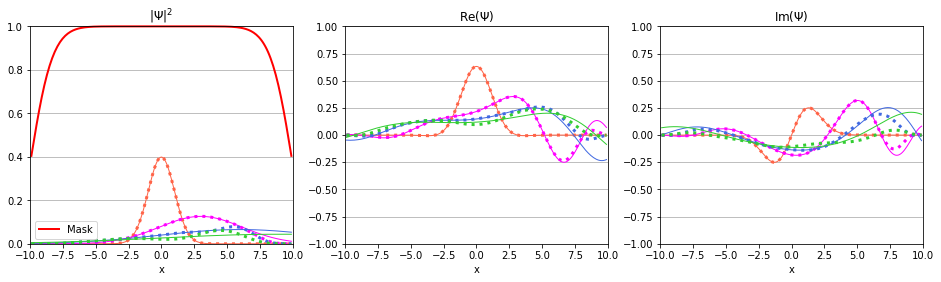

In [34]:
fig, (ax, axR, axI) = plt.subplots(1,3, figsize=(16,4))

ax.set(xlim=(-10, 10), ylim=(0, 1), title=r'$|\Psi|^2$')
ax.grid(axis='y')
ax.set_xlabel('x')
# real \Psi
axR.set(xlim=(-10, 10), ylim=(-1, 1), title=r'$\mathrm{Re}(\Psi)$')
axR.grid(axis='y')
axR.set_xlabel('x')
# imegine \Psi
axI.set(xlim=(-10, 10), ylim=(-1, 1), title=r'$\mathrm{Im}(\Psi)$')
axI.grid(axis='y')
axI.set_xlabel('x')

cs=['tomato', 'magenta', 'royalblue', 'limegreen']

for i in [0, 30, 60, 90]:
    ax.plot(ev.x[1:-1], np.absolute(psiAn[i])**2, lw=1, linestyle='-', c=cs[i//30])
    ax.plot(ev.x[1:-1], np.absolute(psiIt[i])**2, lw=3, linestyle=':', c=cs[i//30])
    axR.plot(ev.x[1:-1], np.real(psiAn[i]), lw=1, linestyle='-', c=cs[i//30])
    axR.plot(ev.x[1:-1], np.real(psiIt[i]), lw=3, linestyle=':', c=cs[i//30])
    axI.plot(ev.x[1:-1], np.imag(psiAn[i]), lw=1, linestyle='-', c=cs[i//30])
    axI.plot(ev.x[1:-1], np.imag(psiIt[i]), lw=3, linestyle=':', c=cs[i//30])

ax.plot(ev.x[1:-1], ev.mask, lw=2, c='red', label='Mask', clip_on=False)
ax.legend()

fig.savefig('figures/comparison.png', dpi=300, bbox_inches='tight')

<IPython.core.display.Javascript object>


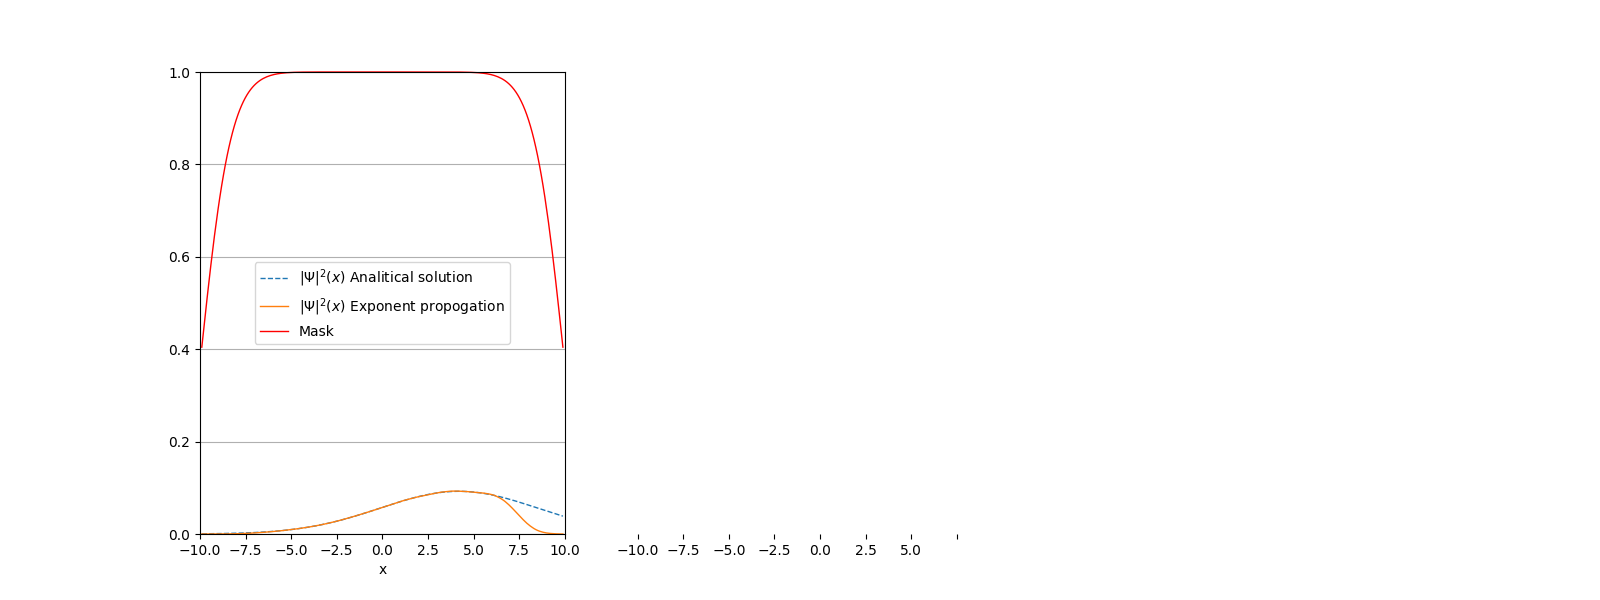

In [5]:
%matplotlib notebook 

# First set up the figure, the axis, and the plot element we want to animate
fig, (ax, axR, axI) = plt.subplots(1,3, figsize=(16,6))
# |\Psi|**2
ax.set(xlim=(-10, 10), ylim=(0, 1))
line1, = ax.plot([], [], lw=1, linestyle='--', label='$|\Psi|^2(x)$ Analitical solution')
# line2, = ax.plot([], [], lw=1, marker='.', label=r'$|\Psi|^2(x)$ Runge-Kutta 4th range')
line3, = ax.plot([], [], lw=1, label=r'$|\Psi|^2(x)$ Exponent propogation')
lineMask, = ax.plot(ev.x[1:-1], ev.mask, lw=1, c='red', label='Mask', clip_on=False)
ax.legend()
ax.grid(axis='y')
ax.set_xlabel('x')
# real \Psi
axR.set(xlim=(-10, 10), ylim=(-1, 1))
line4, = axR.plot([], [], lw=1, linestyle='--', label='$\mathrm{Re}(\Psi(x))$ Analitical solution')
line5, = axR.plot([], [], lw=1, label=r'$\mathrm{Re}(\Psi(x))$ Exponent propogation')
axR.legend()
axR.grid(axis='y')
axR.set_xlabel('x')
# imegine \Psi
axI.set(xlim=(-10, 10), ylim=(-1, 1))
line6, = axI.plot([], [], lw=1, linestyle='--', label='$\mathrm{Im}(\Psi(x))$ Analitical solution')
line7, = axI.plot([], [], lw=1, label=r'$\mathrm{Im}(\Psi(x))$ Exponent propogation')
axI.legend()
axI.grid(axis='y')
axI.set_xlabel('x')

# initialization function: plot the background of each frame
def init():
    line1.set_data([], [])
#     line2.set_data([], [])
    line3.set_data([], [])
    line4.set_data([], [])
    line5.set_data([], [])
    line6.set_data([], [])
    line7.set_data([], [])
    return line1, line3, line4, line5, line6, line7#, line3,

# animation function.  This is called sequentially
def animate(i):
    line1.set_data(ev.x[1:-1], np.absolute(psiAn[i])**2)
#     line2.set_data(ev.x[1:-1], np.absolute(psiRK[i])**2)
    line3.set_data(ev.x[1:-1], np.absolute(psiIt[i])**2)
    line4.set_data(ev.x[1:-1], np.real(psiAn[i]))
    line5.set_data(ev.x[1:-1], np.real(psiIt[i]))
    line6.set_data(ev.x[1:-1], np.imag(psiAn[i]))
    line7.set_data(ev.x[1:-1], np.imag(psiIt[i]))
    axR.set_title(fr'$\tau={ev.tau:>0.2E}$, n={i}')
    return line1, line3, line4, line5, line6, line7 #line2,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=nIter, blit=True)

# # save the animation as an mp4.  This requires ffmpeg or mencoder to be
# # installed.  The extra_args ensure that the x264 codec is used, so that
# # the video can be embedded in html5.  You may need to adjust this for
# # your system: for more information, see
# # http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('figures/basic_animation.mp4', writer=animation.FFMpegWriter(fps=5), dpi=250)

plt.show()  